### Annotations

1. Combining the two csv files with hair annotations from both M and P groups.


In [12]:
import pandas as pd

dfm = pd.read_csv('group_m.csv')
dfp = pd.read_csv('group_p.csv')

combined_df = pd.concat([dfm, dfp], ignore_index=True)

combined_df.to_csv('../result/hair_annotations.csv', index=False)

2. Analysing the agreement between annotators using Fleiss Kappa

In [56]:
from statsmodels.stats.inter_rater import fleiss_kappa

dfr = pd.read_csv('../result/hair_annotations.csv')
ratings = dfr[['Rating_1', 'Rating_2', 'Rating_3', 'Rating_4', 'Rating_5']]

#counting how many times each rating was given per image
def counting(row):
    counts = [0, 0, 0]  #for categories 0, 1, 2
    for v in row:
        counts[int(v)] += 1
    return counts

#creating a dataframe with rating frequencies
rating_counts = ratings.apply(counting, axis=1, result_type='expand')

#computing agreement using fleiss kappa function
data_matrix = rating_counts.values
kappa = fleiss_kappa(data_matrix, method='fleiss')
print(f"Fleiss' Kappa = {kappa:.3f}")

Fleiss' Kappa = 0.706


In [ ]:
from statsmodels.stats.inter_rater import fleiss_kappa

dfr = pd.read_csv('../result/hair_annotations.csv')
ratings = dfr[['Rating_1', 'Rating_2', 'Rating_3', 'Rating_4', 'Rating_5']]

#counting how many times each rating was given per image
def counting(row):
    counts = [0, 0, 0]  #hair amount categories 0, 1, 2
    for v in row:
        counts[int(v)] += 1
    return counts

rating_counts = ratings.apply(counting, axis=1, result_type='expand').values

#computing agreement using fleiss kappa function
kappa = fleiss_kappa(rating_counts, method='fleiss')
print(f"Fleiss' Kappa = {kappa:.1f}")

Fleiss' Kappa = 0.7


- Fleiss' Kappa = 1.0 → Perfect agreement

- Fleiss' Kappa = 0.0 → Agreement no better than chance

- Fleiss' Kappa < 0 → Worse than random (disagreement)

3. Even though kappa score is suggesting that annotations are reliable, we check images that have low agreement and count how many of them there are. We set threshold: less or equal to 4 counts of common rating score --> low agreement image

In [ ]:
from collections import Counter

def common_rating_count(row):
    counts = Counter(row)
    most_common = counts.most_common(1)[0][1]  #count of most common label
    return most_common

ratings['agreement'] = ratings.apply(common_rating_count, axis=1)

#grouping the data based on level of agreement
high_agreement = ratings[ratings['agreement'] >= 4]    
medium_agreement = ratings[ratings['agreement'] == 3]  
low_agreement = ratings[ratings['agreement'] <= 2]      

# Create a summary table
d = {
    'Standard': [
        'High standard (4 or more annotators agree)',
        'Acceptable (exactly 3 agree)',
        'Not acceptable (2 or fewer agree)'
    ],
    'Number of images': [
        len(high_agreement),
        len(medium_agreement),
        len(low_agreement)
    ]
}

overview = pd.DataFrame(d)
overview

C:\Users\Andrius\AppData\Local\Temp\ipykernel_21212\4124500856.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['agreement'] = ratings.apply(common_rating_count, axis=1)


,Standard,Number of images
0,High standard (4 or more annotators agree),247
1,Acceptable (exactly 3 agree),53
2,Not acceptable (2 or fewer agree),0


4. Looking at pictures with acceptable standard to figure out why the disagreement might happen

In [57]:
medium_agreement
dfr.loc[medium_agreement.index].tail()

,File_ID,Group_ID,Rating_1,Rating_2,Rating_3,Rating_4,Rating_5
258,img_2023,16,1,1,1,2,2
264,img_2029,16,1,1,2,1,2
270,img_2035,16,0,1,1,1,0
287,img_2052,16,2,2,1,2,1
299,img_2064,16,2,2,2,1,1


### Hair coverege - feature extraction for model predicting the amount of hair (later used in hair removal to adjust kernel size)

Hair amount is predicted by using laplacian function that detect hair edges, thresholding and calculating coverege by taking a ration between maksed out hair pixels and total number of pixels of the image

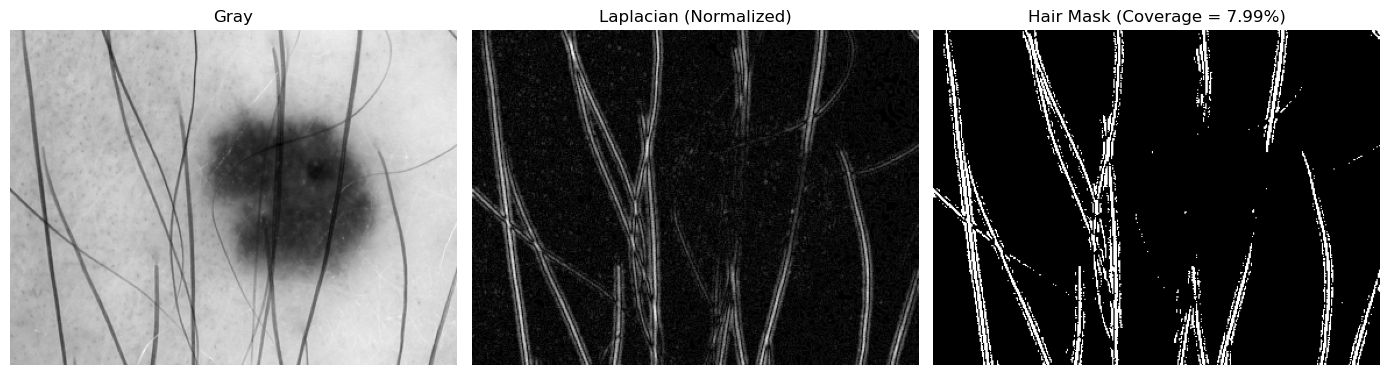

0.0799

In [183]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def hair_coverage(image_path, visual = False):
    img_org = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    #reduces image noise, skin texture, and small bumps before edge detection
    blurred = cv2.GaussianBlur(img_org, (7,7), 0) 

    #laplacian operator highlights areas of rapid intensity change -> edge detection
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F, ksize=3) #cv2.CV_64F sets the data type to 64-bit float so it can hold both positive and negative values
    laplacian_abs = np.absolute(laplacian) #remove negative edges, because we don't care about direction (going from light to dark or vice versa), we care about magnitute
    laplacian_norm = cv2.normalize(laplacian_abs, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8) #scaling edges to 0–255 for thresholding

    threshold_value = 0.3 * 255
    hair_mask = (laplacian_norm > threshold_value).astype(np.uint8)

    #calculating hair coverage
    hair_pixels = np.sum(hair_mask)
    total_pixels = hair_mask.size
    coverage = hair_pixels / total_pixels

    if visual:
        plt.figure(figsize=(14, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img_org, cmap='gray')
        plt.title('Gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(laplacian_norm, cmap='gray')
        plt.title('Laplacian (Normalized)')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(hair_mask * 255, cmap='gray')
        plt.title(f'Hair Mask (Coverage = {coverage:.2%})')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    return round(coverage, 4)

image_path = '../data/skin_images/train_hair/img_2006.png'
hair_coverage(image_path, True)

Extracting feature for every picture

In [213]:
import cv2
import os
import pandas as pd
import numpy as np

image_dir = '../data/skin_images/train_hair/'
data = pd.read_csv('hair_annotations.csv')
#create one label for an image (0,1,2), take the most frequent rating accross annotators
data['gt_label'] = data[['Rating_1', 'Rating_2', 'Rating_3', 'Rating_4', 'Rating_5']].mode(axis=1)[0]
#correction
data['File_ID'] = data['File_ID'].str.replace('.png', '', regex=False)
#data['gt_label'] = data['gt_label'].replace(0, 1)

data['coverage'] = None

for idx, row in data.iterrows():
    img_id = row['File_ID']
    image_path = os.path.join(image_dir, img_id + '.png')

    if os.path.exists(image_path):
        coverage = hair_coverage(image_path, False)
        data.at[idx, 'coverage'] = coverage
    else:
        print(f"Image not found: {image_path}")

data.to_csv('gt_and_coverages.csv', index=False)
data.head(15)

,File_ID,Group_ID,Rating_1,Rating_2,Rating_3,Rating_4,Rating_5,gt_label,coverage
0,img_1572,M,2,2,2,2,2,2,0.1063
1,img_1573,M,2,2,2,2,2,2,0.0433
2,img_1574,M,0,0,0,0,0,0,0.0027
3,img_1575,M,2,2,2,2,2,2,0.0804
4,img_1576,M,2,2,2,2,2,2,0.0845
5,img_1577,M,0,0,0,0,0,0,0.0025
6,img_1578,M,1,0,1,1,1,1,0.0065
7,img_1579,M,0,0,1,0,0,0,0.0746
8,img_1580,M,1,1,1,1,1,1,0.0178
9,img_1581,M,2,2,2,2,2,2,0.0816


In [209]:
print(f'Zeros:{len(data[data['gt_label']==0])}')
print(f'Ones:{len(data[data['gt_label']==1])}')
print(f'Twos:{len(data[data['gt_label']==2])}')


Zeros:0
Ones:213
Twos:87


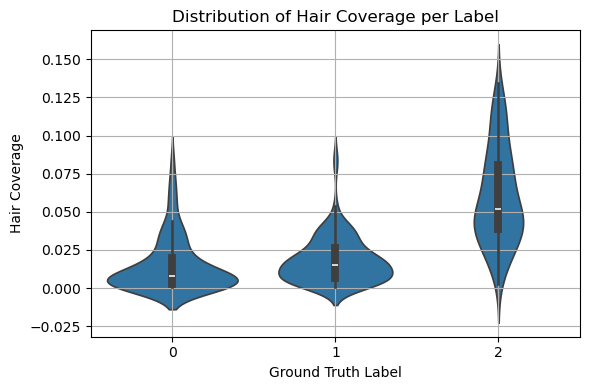

In [215]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.violinplot(x='gt_label', y='coverage', data=data)

plt.xlabel('Ground Truth Label')
plt.ylabel('Hair Coverage')
plt.title('Distribution of Hair Coverage per Label')
plt.grid(True)
plt.tight_layout()
plt.show()

In [216]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define X and y
X = data[['coverage']].astype(float)
y = data['gt_label']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

# Train KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Predict
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.43      0.41        21
           1       0.41      0.41      0.41        22
           2       0.60      0.53      0.56        17

    accuracy                           0.45        60
   macro avg       0.47      0.46      0.46        60
weighted avg       0.46      0.45      0.45        60



In [211]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define X and y
X = data[['coverage']].astype(float)
y = data['gt_label']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

# Train KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Predict
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.82      0.86      0.84        43
           2       0.60      0.53      0.56        17

    accuracy                           0.77        60
   macro avg       0.71      0.69      0.70        60
weighted avg       0.76      0.77      0.76        60

